# Frequentieverdeling van waterstanden op het Dwarsdiep  

Voor het inrichten van het NNN en waterberging in het Dwarsdiep is het nodig om inzicht hebben in de frequentievereling van waterpeilen op het Dwarsdiep. Hiermee kan in beeld gebracht worden welke gronden inunderen bij vrije afwatering op het Dwarsdiep.

Dit notebook bevat een frequentieanalyse van dagwaarden van de waterstand benedenstrooms van gemaal Wemerpolder. Deze zijn afgeleid uit kwartierwaarden over de periode 2012 - 2021. Zie voor een verantwoording het notebook "validatie gemeten waterpeilen Dwarsdiep".

Auteur: Thomas de Meij (Staatsbosbeheer)  
Datum : 14 juni 2021  

## Inlezen dagwaarden waterstand  

De dagwaarden van de waterstand worden ingelezen uit een bestand met gevalideerde data dat in een erdere analyse is opgeslagen. Schrikkeldagen worden verwijderd om de analyse te vereenvoudigen. Alleen metingen in de periode 1 oktober 2012 tot en met 31 maart 2021 worden gebruikt.

In [18]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

sourcedir = r'..\\02_data\\validatie waterpeilen\\'
datadir = r'..\\02_data\\frequentieanalyse wemerpolder\\'
figdir = r'..\03_result\frequentieanalyse wemerpolder\\'

In [19]:
# read daily values from csv
fpath = f'{sourcedir}wemerpolder_dagwaarden_q85.csv'
wmp = pd.read_csv(fpath,index_col='datumtijd',parse_dates=True,
    squeeze=True)

# data stops at 25-03-2021. We accept missing values on the last
# 6 days of march 2021
wmp = wmp.reindex(pd.date_range(start='2012-10-01', end='2021-03-31'))

# remove leap days (=schrikkeldagen)
wmp = wmp[~((wmp.index.month == 2) & (wmp.index.day == 29))].copy()

wmp

2012-10-01   -0.8725
2012-10-02   -0.8700
2012-10-03   -0.8900
2012-10-04   -0.7800
2012-10-05   -0.7000
               ...  
2021-03-27       NaN
2021-03-28       NaN
2021-03-29       NaN
2021-03-30       NaN
2021-03-31       NaN
Name: wmpnap, Length: 3102, dtype: float64

## Tabellen met waterstanden  

Met de meetreeks met dagwaarden van 1 oktober 2012 tot 31 maart 2021 maken we tabellen met waterstanden gesorteerd van hoog naar laag voor alle jaren, uitgesplitst naar zomer en winter. Ook maken we een tabel voor de periode 15 juli - 15 september, de periode waarin hoge waterstanden het maaibeheer in de weg kunnen staan.  Met deze tabellen worden in eenvolgende stap frequenties berekend.   

In [20]:
# select daily water levels in the winter season (october 1st - march 31)
winter = {}
winteryears = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
for year in winteryears:

    startdate = f'{year}-10-01'
    enddate = f'{year+1}-03-31'
    sr = wmp[startdate:enddate].sort_values(ascending=False, 
        inplace=False)

    winter[f'{year}']=sr.values
    
# create dataframe
wtr = DataFrame.from_dict(winter)
wtr.index=pd.Index(range(1,183),name='day')
print(wtr)

       2012    2013    2014  2015    2016    2017    2018    2019    2020
day                                                                      
1   -0.4600 -0.6000 -0.5000 -0.47 -0.6400 -0.5000 -0.5200 -0.4000 -0.5500
2   -0.5125 -0.6700 -0.5425 -0.47 -0.7225 -0.5300 -0.5300 -0.4300 -0.5825
3   -0.5400 -0.7300 -0.6300 -0.53 -0.7300 -0.5700 -0.6500 -0.4625 -0.6125
4   -0.6200 -0.7325 -0.6600 -0.59 -0.7400 -0.6200 -0.6825 -0.5300 -0.6425
5   -0.6300 -0.7325 -0.6800 -0.62 -0.7600 -0.6400 -0.7025 -0.5425 -0.6500
..      ...     ...     ...   ...     ...     ...     ...     ...     ...
178 -0.9000 -0.9300 -0.9300 -0.93 -0.9500 -0.9800 -0.9500 -0.9400     NaN
179 -0.9000 -0.9300 -0.9300 -0.94 -0.9525 -0.9825 -0.9500 -0.9400     NaN
180 -0.9000 -0.9300 -0.9300 -0.94 -0.9600 -0.9900 -0.9500 -0.9400     NaN
181 -0.9000 -0.9400 -0.9300 -0.94 -0.9600 -0.9900 -0.9500 -0.9500     NaN
182 -0.9000 -0.9500 -0.9400 -0.95 -0.9600 -1.0000 -0.9600 -0.9600     NaN

[182 rows x 9 columns]


In [21]:
# select daily water levels in the summer (april 1st - october 1st)
# apr : sep is 30+31+30+31+31+30
summer = {}
summeryears = [2013,2014,2015,2016,2017,2018,2019,2020]
for year in summeryears:

    startdate = f'{year}-04-01'
    enddate = f'{year}-09-30'
    sr = wmp[startdate:enddate].sort_values(ascending=False, 
        inplace=False)

    summer[f'{year}']=sr.values

# create dataframe
smr = DataFrame.from_dict(summer)
smr.index=pd.Index(range(1,184),name='day')
print(smr)

     2013  2014    2015  2016  2017  2018  2019  2020
day                                                  
1   -0.77 -0.74 -0.6600 -0.60 -0.81 -0.71 -0.76 -0.76
2   -0.78 -0.77 -0.7200 -0.77 -0.82 -0.73 -0.80 -0.76
3   -0.78 -0.77 -0.7400 -0.79 -0.83 -0.76 -0.80 -0.78
4   -0.79 -0.78 -0.7525 -0.80 -0.83 -0.76 -0.81 -0.78
5   -0.80 -0.78 -0.7600 -0.80 -0.83 -0.77 -0.81 -0.78
..    ...   ...     ...   ...   ...   ...   ...   ...
179 -0.91 -0.90 -0.9200 -0.93 -0.97 -0.92 -0.92 -0.92
180 -0.91 -0.91 -0.9200 -0.93 -0.97 -0.93 -0.93 -0.92
181 -0.92 -0.91 -0.9200 -0.93 -0.97 -0.93 -0.93 -0.92
182 -0.92 -0.91 -0.9225 -0.94 -0.98 -0.94 -0.93 -0.94
183 -0.92 -0.93 -0.9400 -0.98 -0.99 -0.96 -0.95 -0.95

[183 rows x 8 columns]


In [22]:
# select daily values from mowing period (july 15 - september 15)
mowing = {}
summeryears = [2013,2014,2015,2016,2017,2018,2019,2020]
for year in summeryears:
    
    startdate = f'{year}-07-15'
    enddate = f'{year}-09-15'
    sr = wmp[startdate:enddate].sort_values(ascending=False, 
        inplace=False)

    mowing[f'{year}']=sr.values
    
# create dataframe
mow = DataFrame.from_dict(mowing)
mow.index=pd.Index(range(1,64),name='day')
print(mow)

       2013  2014    2015  2016    2017  2018  2019  2020
day                                                      
1   -0.8300 -0.79 -0.6600 -0.82 -0.8325 -0.71 -0.81 -0.79
2   -0.8300 -0.80 -0.7200 -0.82 -0.8400 -0.73 -0.81 -0.79
3   -0.8325 -0.80 -0.7400 -0.83 -0.8400 -0.76 -0.81 -0.80
4   -0.8400 -0.80 -0.7525 -0.84 -0.8400 -0.77 -0.82 -0.80
5   -0.8400 -0.80 -0.7600 -0.84 -0.8400 -0.77 -0.82 -0.81
..      ...   ...     ...   ...     ...   ...   ...   ...
59  -0.9000 -0.90 -0.9100 -0.92 -0.9600 -0.90 -0.90 -0.92
60  -0.9100 -0.90 -0.9100 -0.92 -0.9700 -0.91 -0.90 -0.92
61  -0.9100 -0.91 -0.9200 -0.93 -0.9700 -0.91 -0.90 -0.92
62  -0.9200 -0.91 -0.9200 -0.93 -0.9800 -0.92 -0.93 -0.94
63  -0.9200 -0.93 -0.9225 -0.93 -0.9900 -0.93 -0.95 -0.95

[63 rows x 8 columns]


In [23]:
# add column with average to copy of dataframe
smravg = smr.sort_index(ascending=True).round(2)
wtravg = wtr.sort_index(ascending=True).round(2)
mowavg = mow.sort_index(ascending=True).round(2)
smravg['avg'] = smravg.mean(axis=1).round(2)
wtravg['avg'] = wtravg.mean(axis=1).round(2)
mowavg['avg'] = mowavg.mean(axis=1).round(2)

# save data to Excel
fpath = f'{datadir}wemerpolder - waterstanden van hoog naar laag.xlsx' 
writer = pd.ExcelWriter(fpath,engine='xlsxwriter')
smravg.to_excel(writer,sheet_name='zomer')
wtravg.to_excel(writer,sheet_name='winter')
mowavg.to_excel(writer,sheet_name='maaiperiode')
writer.save()

### Maximale waterstanden  

Voor het schatten van extreme waarden is het zinvol om voor ieder jaar de maximale waarde te bepalen:

In [24]:
wtrmax = wtr.max(axis=0)
smrmax = smr.max(axis=0)
mowmax = mow.max(axis=0)
dfmax = pd.concat([wtrmax,smrmax,mowmax],axis=1,keys=['winter','summer','mowper'])
dfmax.index.name='year'
dfmax

,winter,summer,mowper
year,,,
2012,-0.46,NaN,NaN
2013,-0.60,-0.77,-0.8300
2014,-0.50,-0.74,-0.7900
2015,-0.47,-0.66,-0.6600
2016,-0.64,-0.60,-0.8200
2017,-0.50,-0.81,-0.8325
2018,-0.52,-0.71,-0.7100
2019,-0.40,-0.76,-0.8100
2020,-0.55,-0.76,-0.7900


In [25]:
fpath = f'{datadir}wemerpolder-jaarmaxima.csv'
dfmax.to_csv(fpath,index=True)
fpath = f'{datadir}wemerpolder-zomermaxima.csv'
smrmax.to_csv(fpath,index=True,header=False)

## Grafieken met frequentieverdelingen  

Met de drie tabellen met gesorteerde dagwaarden voor zomer, winter en het maaiseizoen makenwe grafieken van de cumulatieve frequentieverdeling van waterstanden op het Dwarsdiep.

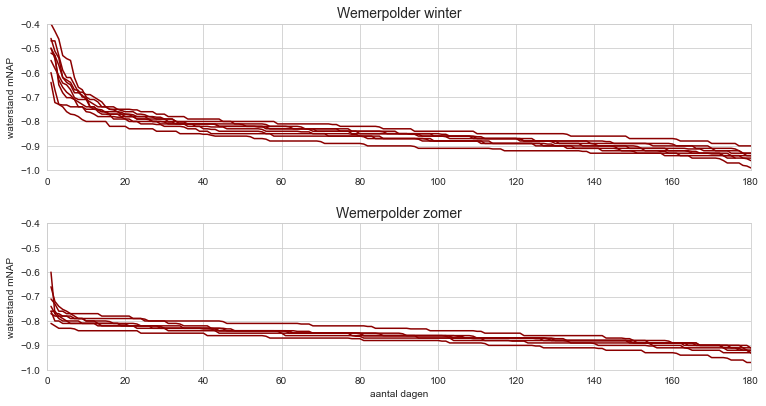

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(11,6) # w,h

for year in wtr:
    ax[0].plot(wtr[year],color='#8b0000')

ax[0].set_title('Wemerpolder winter',fontsize=14)
ax[0].set_xlim(0,180)
ax[0].set_ylim(-1.00,-0.40)
ax[0].grid(b=True, which='both', axis='both',)
ax[0].set_ylabel('waterstand mNAP')

for year in smr:

    ax[1].plot(smr[year],color='#8b0000')
    ax[1].set_title('Wemerpolder zomer',fontsize=14)
    ax[1].set_xlim(0,180)
    ax[1].set_ylim(-1.00,-0.40)
    ax[1].grid(b=True, which='both', axis='both',)
    ax[1].set_ylabel('waterstand mNAP')
    ax[1].set_xlabel('aantal dagen')

fig.tight_layout(pad=2.0)
fpath = f'{figdir}wemerpolder dagwaarden_frequenties.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')


## Waterstanden met lage frequenties

Bovenstaande grafieken laten zien dat het boezempeil door het jaar heen erg stabiel is (zowel het zomergemiddelde als het wintergemiddelde is -0,85 m NAP). Om iets te zeggen over de kans op inundaties kijken we wat meer in detail naar de  hoogste waterstanden. In de grafieken worden steeds de jaren met de hoogste (donkerblauw) en laagste (lichtblauw) waterstanden apart aangegegeven.

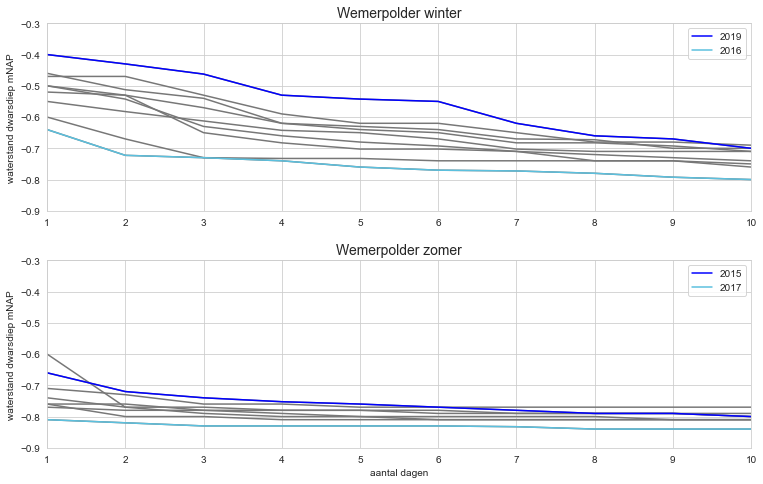

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(11,7) # w,h
fig.tight_layout(pad=3.0)

maxday = 10
minday = 1

for year in wtr:
    ax[0].plot(wtr[year],color='#777777')

ax[0].plot(wtr['2019'],color='#0000ff',label='2019') # highest
ax[0].plot(wtr['2016'],color='#5bc0de',label='2016') # lowest

ax[0].set_title('Wemerpolder winter',fontsize=14)
ax[0].set_xlim(minday,maxday)
ax[0].set_ylim(-0.9,-0.30)
ax[0].grid(b=True, which='both', axis='both',)
ax[0].set_ylabel('waterstand dwarsdiep mNAP')
ax[0].legend(loc="upper right")

for year in smr:
    ax[1].plot(smr[year],color='#777777')

ax[1].plot(smr['2015'],color='#0000ff',label='2015') # highest
ax[1].plot(smr['2017'],color='#5bc0de',label='2017') # lowest

ax[1].set_title('Wemerpolder zomer',fontsize=14)
ax[1].set_xlim(minday,maxday)
ax[1].set_ylim(-0.9,-0.30)
ax[1].grid(b=True, which='both', axis='both',)
ax[1].set_ylabel('waterstand dwarsdiep mNAP')
ax[1].set_xlabel('aantal dagen')
ax[1].legend(loc="upper right")

fpath = f'{figdir}wemerpolder - hoge waterstanden winter en zomer.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')


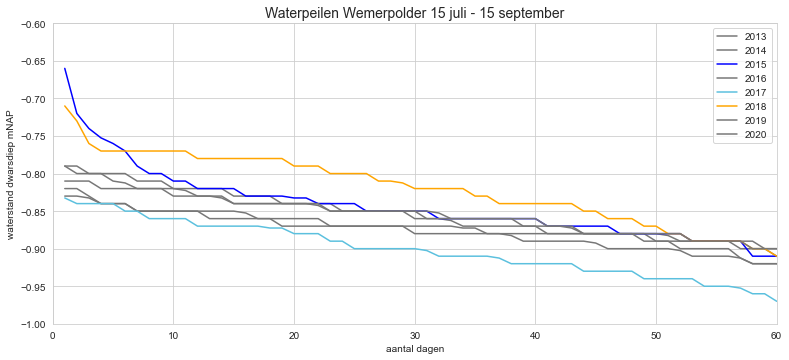

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(11,5) # w,h
fig.tight_layout(pad=2.0)

for year in mow:

    if year=='2015':
        ax.plot(mow[year],color='#0000ff',label=year)
    elif year=='2018':
        ax.plot(mow[year],color='#ffa500',label=year)
    elif year=='2017':
        ax.plot(mow[year],color='#5bc0de',label=year)
    else:
        ax.plot(mow[year],color='#777777',label=year)

    ax.set_title('Waterpeilen Wemerpolder 15 juli - 15 september',fontsize=14)
    ax.set_xlim(0,60)
    ax.set_ylim(-1.00,-0.60)
    ax.grid(b=True, which='both', axis='both',)
    ax.set_ylabel('waterstand dwarsdiep mNAP')
    ax.set_xlabel('aantal dagen')
    ax.legend(loc="upper right")

fpath = f'{figdir}wemerpolder - hoge waterstanden maaiperiode.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')

## Waterstanden in de maaiperiode  

Hoge waterstanden in de zomer maken percelen moeilijk toegankelijk voor maaibeheer. Daarom kijken we specifiek naar deze periode. Eerst een beeld van de cumulatieve frequentieverdeling en vervolgens een grafiek met het verloop vanhet boezempeil in verschillende jaren.

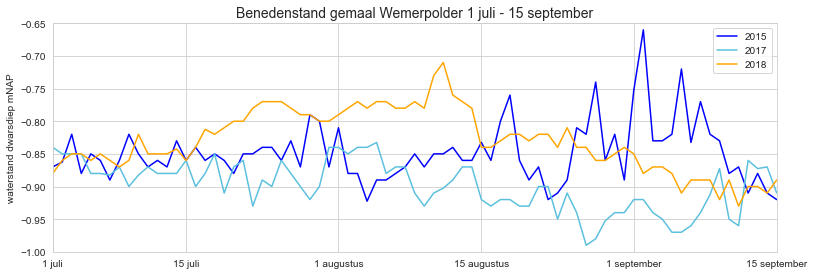

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(11,4) # w,h
fig.tight_layout(pad=2.0)

years = [2015,2017,2018]
colors = ['#0000ff','#5bc0de','#ffa500']

for i,year in enumerate(years):
    waterlevels = wmp[f'{year}-07-01':f'{year}-09-15'].values
    ax.plot(waterlevels,color=colors[i],label=f'{year}')
    
    ax.set_xticks([0,14,30,45,61,76])
    ax.set_xticklabels(['1 juli','15 juli','1 augustus','15 augustus','1 september','15 september'])
    ax.set_title('Benedenstand gemaal Wemerpolder 1 juli - 15 september',fontsize=14)
    ax.set_xlim(0,76)
    ax.set_ylim(-1.00,-0.65)
    ax.grid(b=True, which='both', axis='both',)
    ax.set_ylabel('waterstand dwarsdiep mNAP')
    ax.legend(loc="upper right")

fpath = f'{figdir}wemerpolder - waterstanden zomer 2018.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')

## Opslaan statistieken  

Als naslag worden tabellen opgeslagen met statistieken van de data.

In [30]:
fpath = f'{datadir}wemerpolder - statistieken waterstanden.xlsx'
writer = pd.ExcelWriter(fpath,engine='xlsxwriter')

smrstat = smr.describe()
smrstat['mean'] = smrstat.mean(numeric_only=True, axis=1)
smrstat.to_excel(writer,sheet_name='zomer')

wtrstat = wtr.describe()
wtrstat['mean'] = wtrstat.mean(numeric_only=True, axis=1)
wtrstat.to_excel(writer,sheet_name='winter')

mowstat = mow.describe()
mowstat['mean'] = mowstat.mean(numeric_only=True, axis=1)
mowstat.to_excel(writer,sheet_name='maaiperiode')

writer.save()

## Vergelijking met analyse Prolander  

Ter onderbouwing van het inrichtingsplan heeft Prolander eerder al een vergelijkbare frequentieanalyse uitgevoerd van de waterpeilen bij Wemerpolder en daarmee inundatiekaarten gemaakt (Memo "Besluitvorming inrichtingsvorm polders Oude Riet en Wemerpolder", Eric Blom 16-04-2021). De frequentieanalyse door Prolander is gebaseerd op kwartierwaarden in de periode 1 april - 1 november. 

Om een beeld te krijgen van de mate van overeenkomst tussen de frequentieanalyse van dagwaarden voor de periode 1 april - 1 oktober met de analyse van Prolander zijn beide cumulatieve frequentieanalyses hieronder weergegeven in één figuur. De omrekening van frequenties naar dagen is in beide gevallen uitgevoerd voor 214 dagen, de periode waarop de frequentieanalyse van Prolander is gebaseerd. De indeling is klassen van 5 cm is eveneens overeenkomstig de werkwijze van Prolander.


In [31]:
# klasseindeling Prolander
prolander_bins = [-1.35,-1.0,-0.95,-0.90,-0.85,-0.80,-0.75,-0.70,-0.65,-0.60,-0.55,-0.50] #,0.135]

# resultaat frequentieanalyse Prolander
prolander_dagen = [214,206,160,66,15,3.5,1.5,1.0,0.5,0.2,0.1]

# groeiseizoen : 1 april - 1 november : 30+31+30+31+31+30+31 = 214 dagen
season_days = 214

# zomer : 1 mei - 1 september : 31+30+31+31+30 = 153 dagen
summer_days = 153

In [32]:
# calculate cumulative histogram for dauly values shown above
wmphist, bin_edges = np.histogram(wmp,bins=prolander_bins,density=False)
wmpcum = (1-np.cumsum(wmphist)/np.sum(wmphist))*season_days

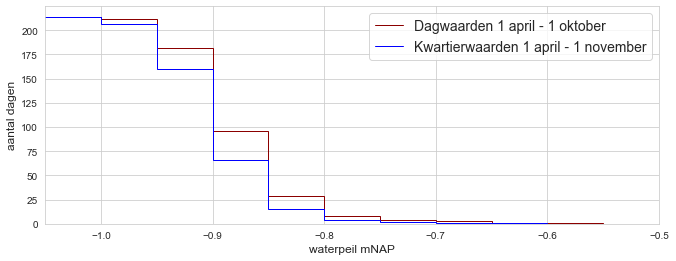

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))

ax.stairs(wmpcum, prolander_bins, label='Dagwaarden 1 april - 1 oktober', color='#8b0000')

##n, bins, patches = ax.hist(vals, bins, density=True, histtype='step',cumulative=True, label='Dagwaarden Wemerpolder')
ax.stairs(prolander_dagen, prolander_bins, label='Kwartierwaarden 1 april - 1 november', color='#0000ff')

ax.set_ylabel('aantal dagen',fontsize=12)
ax.set_xlabel('waterpeil mNAP',fontsize=12)
ax.set_xlim(-1.05,-0.5)
ax.legend(fontsize=14)

fpath = f'{figdir}wemerpolder - vergelijking kwartierwaarden en dagwaarden.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')